<h1>Table of contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Settings" data-toc-modified-id="Settings-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Settings</a></span></li><li><span><a href="#Input-atmospheric-profile" data-toc-modified-id="Input-atmospheric-profile-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input atmospheric profile</a></span></li><li><span><a href="#The-RCEMIP-profile" data-toc-modified-id="The-RCEMIP-profile-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The RCEMIP profile</a></span></li><li><span><a href="#The-WRF-profile" data-toc-modified-id="The-WRF-profile-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The WRF profile</a></span></li><li><span><a href="#Calculation-of-$\eta$-values" data-toc-modified-id="Calculation-of-$\eta$-values-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Calculation of $\eta$-values</a></span></li><li><span><a href="#Notes-on-the-WRF-implementation" data-toc-modified-id="Notes-on-the-WRF-implementation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Notes on the WRF implementation</a></span><ul class="toc-item"><li><span><a href="#Maintenance-of-hydrostatic-balance" data-toc-modified-id="Maintenance-of-hydrostatic-balance-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Maintenance of hydrostatic balance</a></span></li><li><span><a href="#Perturbation-in-quarter_ss-case" data-toc-modified-id="Perturbation-in-quarter_ss-case-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Perturbation in <code>quarter_ss</code> case</a></span></li><li><span><a href="#A-note-on-reading-the-WRF-code" data-toc-modified-id="A-note-on-reading-the-WRF-code-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>A note on reading the WRF code</a></span></li></ul></li></ul></div>

# Calculation of WRF $\eta$-values for given mass height layers

The document contains code that defines WRF model levels such that the initial state has vertical levels aligned with prescribed heights. 

First, import third-party libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray

And import custom libraries. There are two custom packages:
* `rcemip_profile.py` contains code to calculate RCEMIP profiles.
* `wrf_profile.py` contains code to calculate WRF profiles.

In [2]:
import modules.rcemip_profile as rcemip
import modules.wrf_profile as wrfprof 

## Settings

Settings are assigned here. `heights` are the heights in m for which we want WRF eta level values.

In [3]:
# Analysis settings.
heights = rcemip.suggested_heights()     # The heights for which to calculate WRF eta levels [m].
surface_q = 0.01865                      # Surface water vapour mixing ratio [kg kg-1].
surface_p = 1014.8                       # Surface pressure [hPa].
surface_T = 300                          # Surface temperature [K].
ztop = 33250                             # Model-top height [m].

# Plot settings.
plt.rcParams['figure.figsize'] = [15, 5] # Figure size for non-facetted plots.
plt.rcParams['font.size'] = 14           # Font size for plots.

## Input atmospheric profile

WRF ideal cases require an input profile that prescribes:

* Surface pressure $\hat{p}_s$ (hPa) (referred to as $p_s$ in Pa in the equations below).
* Surface dry potential temperature $\theta_s$ (K).
* Surface water vapour mixing ratio $\hat{q}_{vs}$ (g kg$^{-1}$) (converted to $q_{vs}$ in kg kg$^{-1}$ below).
* Level heights $z$ (m), and per height:
    - Dry potential temperature $\theta$ (K).
    - Water vapour mixing ratio $\hat{q}_v$ (g kg$^{-1}$), converted to $q_v$ in kg kg$^{-1}$ below.
    - Wind speeds $U$ and $V$ (m s$^{-1}$).

In the WRF `input_sounding` file, the first line contains the surface variables $\hat{p}_s$, $\theta_s$, $\hat{q}_{vs}$. The proceeding lines contain $z$, $\theta(z)$, $\hat{q}_v(z)$, $U(z)$, $V(z)$. Here is the top of the input profile we use:

In [4]:
!head /g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/input_sounding

1014.8	298.7434	18.65		
37	298.8856	18.47783	0.0	0.0
112	299.1739	18.131		0.0	0.0
194	299.4894	17.75518	0.0	0.0
288	299.8511	17.32883	0.0	0.0
395	300.2631	16.84952	0.0	0.0
520	300.7447	16.29795	0.0	0.0
667	301.3112	15.66121	0.0	0.0
843	301.9897	14.91642	0.0	0.0
1062	302.8342	14.01735	0.0	0.0


## The RCEMIP profile

In our case, the input profiles are for RCE comparison, so the profile is generated using equations set out in [Wing et al., 2018](https://gmd.copernicus.org/articles/11/793/2018/) for the radiative–convective equilibrium model intercomparison project (RCEMIP). Wing et al. also provides suggested model level heights which we assume are mass-point heights. The file `rcemip_profile.py` contains code that uses their equations to calculate input profiles. Here are initial profiles calculated using RCEMIP suggested heights (the plots are cut at 18600 m to match the first two figures in Wing et al.'s Figure 2):

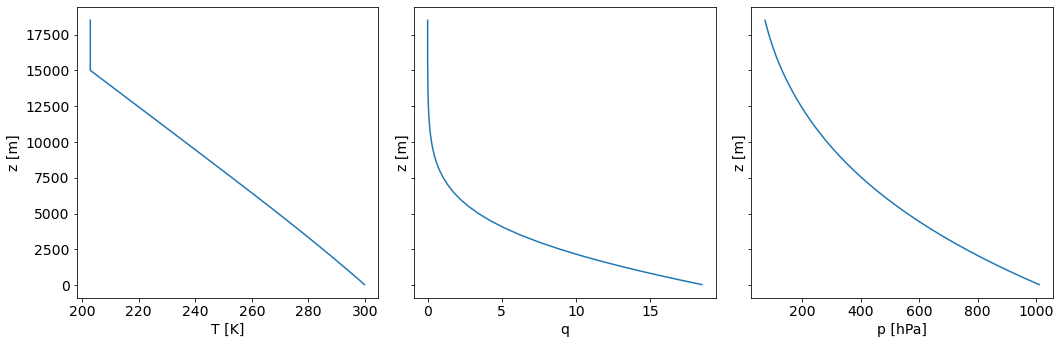

In [5]:
rcemip.plot_default_profile()

## The WRF profile

The equations that WRF uses are set out in the [WRF ARW tech note version 4](https://www2.mmm.ucar.edu/wrf/users/docs/technote/contents.html). Here is how WRF deals with the initial profile and calculates the dry and moist pressure at each profile height in the ideal simulation case.

Moist potential temperature is calculated from dry potential temperature $\theta$ (K) and water vapour mixing ratio $q_v$ (kg kg$^{-1}$) using (Tech Note page 8):

$$
\theta_m = \theta (1+R_v/R_d) q_v,
$$

where $R_d = 287$ J kg$^{-1}$ K$^{-1}$ is the gas constant for dry air, and $R_v=461.6$ J kg$^{-1}$ K$^{-1}$ is the gas constant for water vapour. 

Density $\rho$ (kg m$^{-3}$) for a given pressure and moist potential temperature is calculated using Tech Note Equation 5.2:

$$
\rho = 1 \bigg/ \left[ \frac{R_d \theta_m}{p_0} \left(\frac{p}{p_0}\right)^{-\frac{c_v}{c_p}} \right]
$$

where $c_p = 7 R_d/2$ J kg$^{-1}$ K$^{-1}$ is the specific heat of dry air at constant pressure, $c_v = c_p - R_d$ J kg$^{-1}$ K$^{-1}$ is the specific heat of dry air at constant volume, and $p_0$ (Pa) is a reference pressure set to $100000$ Pa ($1000$ hPa).

For a layer that has bottom height of $z$ m and a thickness of $dz$ m, the pressure and density at the top edge of the layer are calculated from the pressure and density at the bottom of the layer, by iteratively calculating pressure then density. Moist pressure at the top of the layer is calculated using

$$
p_{z+dz} = p_z - dz \overline{\rho_d} g (1 + \overline{q_v})
$$

where $\overline{\rho_d} = (\rho_z + \rho_{z+dz})/2$ and $\overline{q_v} = ({q_v}_z + {q_v}_{z+dz})/2$. Density at the top of the layer $\rho_{z+dz}$ is then calculated for pressure $p_{z+dz}$ using the density equation above and $\theta_m$ for the top of the layer. These two steps are started with $\rho_{z+dz} = \rho_z$ and then run and updated 10 times to converge on a solution.

Surface pressure $p_s$, surface dry potential temperature $\theta_s$, and surface water vapour mixing ratio $q_{vs}$ are known. Although $q_{vs}$ is known, WRF uses $q_{vs} = q_v(z_1)$ where $z_1$ is the first sounding height in its calculations. WRF first iterates up the column starting from the surface values to find the moist pressure and density at each sounding level. It then iterates down the column from the last sounding level, converting moist pressure to dry pressure at each level using

$$
{p_d}_{z-dz} = {p_d}_z + dz \frac{{\rho_d}_{z-dz} + {\rho_d}_z}{2} g,
$$

where for the top of the model it is assumed that $p_d$ = $p$.

WRF first calculates a dry profile by setting $q_v = 0$. The model top pressure $p_t$ is calculated using linear extrapolation of dry pressure from the dry profile to the specified model-top height. A moist profile is then calcualted using the sounding values of $q_v$. The dry surface pressure is extrapolated from both profiles.

## Calculation of $\eta$-values

To get the $\eta$ values for given heights, first calculate the RCEMIP profile for the given heights to get the input sounding.

In [6]:
sounding = rcemip.initial_profile(z=rcemip.suggested_heights())

Use WRF's method to use the sounding information to calculate dry hydrostatic pressure at each of the sounding heights. Note that all values of water vapour mixing ratio $q$ are set to zero so that a dry profile is calculated.

In [7]:
wrf_profile_dry = wrfprof.compute_wrf_profile(p_s=surface_p, T_s=surface_T, z=sounding.z,
                                          theta=sounding.theta, q_v=sounding.q, dry=True)

Dry WRF profile from sounding:
Surface pressure:			1014.8 hPa
Surface temperature:			300 K
Surface mixing ratio:			0.0 kg kg-1
Surface potential temperature:		298.743363657743 K
Surface density:			1.1786295005807201 kg m-3


Also calculate the moist sounding to get both moist and dry hydrostatic pressure at each sounding height.

In [8]:
wrf_profile_moist = wrfprof.compute_wrf_profile(p_s=surface_p, T_s=surface_T, z=sounding.z,
                                                theta=sounding.theta, q_v=sounding.q, dry=False)

Moist WRF profile from sounding:
Surface pressure:			1014.8 hPa
Surface temperature:			300 K
Surface mixing ratio:			0.018477833201020075 kg kg-1
Surface potential temperature:		298.743363657743 K
Surface density:			1.144612696796989 kg m-3


We use the WRF method to extrapolate the dry pressure at the model top and surface, using the dry sounding.

In [9]:
top_p_dry, interp_surface_p_dry, column_mass_dry = wrfprof.base_state_pressures(p=wrf_profile_dry.p_dry[1:], 
                                                                                z=wrf_profile_dry.z[1:], 
                                                                                ztop=ztop)

Interpolated model-top pressure:	5.831144646701367 hPa
Interpolated surface pressure:		1014.7775193727508 hPa
Column mass:				1008.9463747260495 hPa


And using the moist sounding:

In [10]:
top_p_moist, interp_surface_p_moist, p_c_moist = wrfprof.base_state_pressures(p=wrf_profile_moist.p_dry[1:], 
                                                                              z=wrf_profile_moist.z[1:], 
                                                                              ztop=ztop)

Interpolated model-top pressure:	5.925167576509378 hPa
Interpolated surface pressure:		1009.742561685317 hPa
Column mass:				1003.8173941088077 hPa


Now using the moist profile we can calculate the values of eta for each full level, so that the desired heights are given. Here are the results ready to copy into a `namelist.input` file for WRF.

In [11]:
eta = wrfprof.eta_for_pressure(p_dry=wrf_profile_moist.p_dry, p_top=top_p_dry)
print(np.array2string(eta, formatter={'float_kind':'{0:.6f},'.format}))

[1.000000, 0.991738, 0.983335, 0.973640, 0.962746, 0.950408, 0.935878,
 0.919184, 0.899021, 0.874113, 0.844846, 0.808833, 0.770664, 0.726680,
 0.684175, 0.643323, 0.604718, 0.567640, 0.532683, 0.499129, 0.467574,
 0.437300, 0.408905, 0.381672, 0.356201, 0.331778, 0.309005, 0.287170,
 0.266877, 0.247418, 0.229399, 0.212116, 0.196176, 0.180877, 0.166832,
 0.153340, 0.141016, 0.129162, 0.118397, 0.108188, 0.099119, 0.090468,
 0.082832, 0.075498, 0.069073, 0.062852, 0.057449, 0.052169, 0.047630,
 0.043144, 0.039336, 0.035521, 0.032330, 0.029082, 0.026412, 0.023643,
 0.021413, 0.019048, 0.017190, 0.015168, 0.013624, 0.011890, 0.010612,
 0.009122, 0.008068, 0.006785, 0.005920, 0.004810, 0.004106, 0.003143,
 0.002573, 0.001735, 0.001280, 0.000546, 0.000187,]


## Notes on the WRF implementation

### Maintenance of hydrostatic balance

WRF knows the value of $\eta$ (set by the user) and calculates geopotential heights slightly differently.  For example, for the base (dry) geopotential, the pressures at the full $\eta$-levels are calculated:

$$
p_d = \eta(p_s - p_t) + p_t
$$

and the base geopotential in exact hydrostatic balance is found through iteration, using:

$$
\phi_k = \phi_{k-1} - (\eta_k - \eta_{k-1})  (p_s - p_t) \frac{1}{{\rho_d}_{k-1}}
$$

Perturbation geopotential (dry - moist) is found iteratively so that the model remains in exact hydrostatic balance. Using our newly calculated $\eta$-level values we can check how much difference this iterative approach makes. First calculate the geopotentials using the WRF approach and the new $\eta$-levels.

In [12]:
phi_base, phi_pert = wrfprof.base_state_geopotential(eta=xarray.DataArray(eta), 
                                                     dry_profile=wrf_profile_dry, 
                                                     moist_profile=wrf_profile_moist, 
                                                     p_surface_dry=interp_surface_p_dry,
                                                     p_surface_moist=interp_surface_p_moist, 
                                                     p_top=top_p_dry)

Model-top pressure:		583.1144646701367 Pa
Dry column mass:		100894.63747260494 Pa
Moist column mass:		100391.14170386156 Pa
Perturbation column mass:	-503.495768743378 Pa


Then calculate heights from the base and perturbation geopotential and compare them to the heights we prescribed for the model.

In [13]:
wrf_heights = wrfprof.heights(eta, phi_base=phi_base, phi_pert=phi_pert)
wrfprof.compare_arrays(x=wrf_heights.z_full.values, ref=heights, unit='m')

Maximum absolute difference:		5.15 m
Bias:					2.28 m
Maximum relative absolute difference:	0.17%


In WRF the full (moist) geopotential height for the initial model state is stored in the variable `Z_BASE` in the `wrfinput` file. The values of `Z_BASE` should be close to the following values, with differences (probably) due to the fact that python uses 64-bit floats and WRF uses 32-bit floats.

In [14]:
wrf_heights.z_full.values

array([   37.06383468,   112.06626155,   194.087598  ,   288.11095396,
         395.14363456,   520.20223839,   667.2731319 ,   843.41100985,
        1062.65383952,  1331.95077789,  1665.53961629,  2056.86354246,
        2507.71620831,  3002.78322029,  3502.82735566,  4002.77476024,
        4502.82523897,  5002.7657451 ,  5502.82355904,  6002.75605257,
        6502.82236805,  7002.74553208,  7502.82173886,  8002.73400057,
        8502.82177128,  9002.7212358 ,  9502.82259844, 10002.70696657,
       10502.82439433, 11002.69085923, 11502.8273838 , 12002.67249947,
       12502.83185611, 13002.65136789, 13502.83818385, 14002.62680721,
       14502.84684914, 15002.59897359, 15502.92615463, 16002.56351767,
       16502.95084934, 17002.52151814, 17502.98003281, 18002.47173334,
       18503.01453259, 19002.41272878, 19503.05532908, 20002.34280516,
       20503.10358377, 21002.25994942, 21503.16067286, 22002.16177657,
       22503.22822697, 23002.04546091, 23503.30817832, 24001.90765429,
      

### Perturbation in `quarter_ss` case

In the WRF initialisation code for ideal cases, the base and perturbation geopotential are calculated; then a thermal perturbation is added to kick of convection in the `quarter_ss` case and the perterbation geopotential is recalculted to regain hydrostatic balance. 

I think there was a bug in the WRF initialisation code so that in the rebalancing part, the perterbation geopotential for the highest model level was incorrectly calculated (the index on `c1h` and `c2h` should be `k-1` to match the main perturbation geopotential calculation code, but was set to `k`). I fixed this bug in my WRF version.

The variable `Z_BASE` in the `wrfinput` file is the height of each layer in a corner pixel of the model that is not affected by this thermal perturbation.

### A note on reading the WRF code

When `hybrid_opt = 0`, the following are set in the WRF code for full model levels:

```
c1f = delta(eta_half) / delta(znu) = 1
c2f = 0
c3f = eta on full levels
c4f = 0
```

and the following variables are set for half levels:

```
c1h = delta(eta) / delta(znw) = 1
c2h = 0
c3h = eta on half levels
c4h = 0
```